<a href="https://colab.research.google.com/github/prollyyes/MLBrainTumorClassification/blob/main/homework_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MRI Brain Tumor Detection Via Machine Learning

These models have the goal of determining whether or not a MRI scan presents the typical indicators of a brain tumor.

**From the dataset page:**


*A Brain tumor is considered as one of the most aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and 36 percent for women. Brain Tumors are classified as: Benign Tumor, Malignant Tumor, Pituitary Tumor, etc. Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties.*

*Brain Tumors are complex. There are a lot of abnormalities in the sizes and location of the brain tumor(s). This makes it really difficult for complete understanding of the nature of the tumor. Also, a professional Neurosurgeon is required for MRI analysis. Often times in developing countries the lack of skillful doctors and lack of knowledge about tumors makes it really challenging and time-consuming to generate reports from MRI’. So an automated system on Cloud can solve this problem.*



The dataset used for training the models are trained on the datasets publicly [available on Kaggle here](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)

We will start with installing one of the most important modules: tensorflow

In [1]:
!pip install -q tensorflow

... then, import the rest to the working environment for colab...

In [2]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0

Now, get the actual files. ~Kaggle was kind enough to already split the data 80/20 into train/test~!

***

**UPDATE**

I suspect the split isn't well formed. I will redo my own splits, but instead do 70/15/15 train/validation/test splits.

In [3]:
import os, shutil

# paths in Google Colab
drive_root = "/content/drive/MyDrive/mri_brain_tumor_ml"
local_root = "/content/brain_tumor_merged"

# copy to /content for speed
if not os.path.exists(local_root):
    shutil.copytree(drive_root, local_root)
else:
    print(f"Local root already exists at: {local_root}")

local_train = os.path.join(local_root, "Training")
local_test  = os.path.join(local_root, "Testing")

print("Train subfolders:", os.listdir(local_train))
print("Test subfolders:", os.listdir(local_test))

Train subfolders: ['pituitary_tumor', 'glioma_tumor', 'meningioma_tumor', 'no_tumor']
Test subfolders: ['pituitary_tumor', 'glioma_tumor', 'meningioma_tumor', 'no_tumor']


In [4]:
import os, shutil  # (optional here, but safe if cell is run independently)

merged_dir = "/content/merged_brain_tumor"
classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# create merged dir & class subfolders
os.makedirs(merged_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(merged_dir, cls), exist_ok=True)

# helper to copy images
def copy_images(src_root, dst_root):
    for cls in classes:
        src_path = os.path.join(src_root, cls)
        dst_path = os.path.join(dst_root, cls)

        if not os.path.isdir(src_path):
            print(f"Warning: {src_path} does not exist, skipping.")
            continue

        for fname in os.listdir(src_path):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                src_file = os.path.join(src_path, fname)
                # avoid name collision by adding a folder tag
                new_fname = f"{os.path.basename(src_root)}_{fname}"
                dst_file = os.path.join(dst_path, new_fname)

                shutil.copy2(src_file, dst_file)

# finally, copy train + test images into merged folder
copy_images(local_train, merged_dir)
copy_images(local_test, merged_dir)

print("Merging complete")

Merging complete


Now, collect all image paths and labels

In [5]:
import glob

image_paths = []
labels = []

for idx, cls in enumerate(classes):
  cls_dir = os.path.join(merged_dir, cls)
  files = glob.glob(os.path.join(cls_dir, "*"))
  image_paths.extend(files)
  labels.extend([idx] * len(files))

len(image_paths), len(labels)

(3264, 3264)

Now, we will focus on creating stratified Train/Val/Test splits.

The first step is creating the train and temp splits (so we get a 70/30 partition)
Then, we will further split the temp into two, equal-sized, splits.

This will achieve the 70/15/15 split I was aiming for.

In [6]:
from sklearn.model_selection import train_test_split

X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.3, random_state=42, stratify=labels)

# split temp into 15/15

X_val_paths, X_test_paths, y_val, y_test = train_test_split(X_temp_paths, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


print("Train:", len(X_train_paths))
print("Val:", len(X_val_paths))
print("Test:", len(X_test_paths))


# also, let's perform a sanity check on the new distributions to ensure the expected splits are produced

def show_distribution(labels, name):
  uniq, counts = np.unique(labels, return_counts=True)
  print(name)
  for u, c in zip(uniq, counts):
    print(f"{classes[u]}: {c}")
  print()

show_distribution(y_train, "Train")
show_distribution(y_val, "Val")
show_distribution(y_test, "Test")

Train: 2284
Val: 490
Test: 490
Train
glioma_tumor: 648
meningioma_tumor: 656
no_tumor: 350
pituitary_tumor: 630

Val
glioma_tumor: 139
meningioma_tumor: 140
no_tumor: 75
pituitary_tumor: 136

Test
glioma_tumor: 139
meningioma_tumor: 141
no_tumor: 75
pituitary_tumor: 135



I should keep in mind the disproportionate no_tumor samples across all classes.

In [7]:
# get the classes names and label mapping (from Training)

classes = sorted(os.listdir(merged_dir))
print("Classes:", classes)

label_to_idx = {c: i for i, c in enumerate(classes)}
print("Label to Index:", label_to_idx)

idx_to_label = {i: c for c, i in label_to_idx.items()}
print("Index to Label:", idx_to_label)

Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Label to Index: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Index to Label: {0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}


I will now implement a helper function that lets us load one split (either train or test)

It will traverse each class within the split, load and resize images to 224x224, apply ~VGG16~ EfficientNet preprocessing, and finally return X_images and y_labels

In [8]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input # changed from VGG16 to EfficientNetB0
img_size=(224,224)
def load_and_preprocess_images(path_list, img_size=img_size):
  n = len(path_list)
  X = np.zeros((n, img_size[0], img_size[1], 3), dtype=np.float32)

  for i, path in enumerate(path_list):
    if i % 200 == 0:
      print(f"Loading image {i+1}/{n}: {path}")
    img = load_img(path, target_size=img_size)
    arr = img_to_array(img)
    arr = preprocess_input(arr) # efficientnet preprocessing

    X[i] = arr # store the preprocessed image

  return X

In [9]:
img_size = (224, 224)

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    pooling='avg',  # gives 1D feature vector per image
)
base_model.trainable = False  # freeze for now

base_model.summary()  # optional, just to see architecture

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

Now, we will load the existing splits separately

In [10]:
print("Loading Train images...")
X_train_images = load_and_preprocess_images(X_train_paths, img_size)

print("Loading Val images...")
X_val_images = load_and_preprocess_images(X_val_paths, img_size)

print("Loading Test images...")
X_test_images = load_and_preprocess_images(X_test_paths, img_size)

print("Shapes:",
      X_train_images.shape,
      X_val_images.shape,
      X_test_images.shape)

Loading Train images...
Loading image 1/2284: /content/merged_brain_tumor/pituitary_tumor/Training_p (241).jpg
Loading image 201/2284: /content/merged_brain_tumor/glioma_tumor/Training_gg (125).jpg
Loading image 401/2284: /content/merged_brain_tumor/meningioma_tumor/Training_m2 (15).jpg
Loading image 601/2284: /content/merged_brain_tumor/pituitary_tumor/Testing_image(97).jpg
Loading image 801/2284: /content/merged_brain_tumor/glioma_tumor/Training_gg (31).jpg
Loading image 1001/2284: /content/merged_brain_tumor/glioma_tumor/Testing_image(47).jpg
Loading image 1201/2284: /content/merged_brain_tumor/pituitary_tumor/Training_p (516).jpg
Loading image 1401/2284: /content/merged_brain_tumor/pituitary_tumor/Training_p (729).jpg
Loading image 1601/2284: /content/merged_brain_tumor/glioma_tumor/Training_gg (615).jpg
Loading image 1801/2284: /content/merged_brain_tumor/pituitary_tumor/Training_p (186).jpg
Loading image 2001/2284: /content/merged_brain_tumor/pituitary_tumor/Training_p (753).jpg


Then, pass them through the frozen EfficientNetB0 to get the **feature vectors**

In [11]:
batch_size = 32

print("Extracting Train features...")
X_train_feat = base_model.predict(X_train_images, batch_size=batch_size, verbose=1)

print("Extracting Val features...")
X_val_feat = base_model.predict(X_val_images, batch_size=batch_size, verbose=1)

print("Extracting Test features...")
X_test_feat = base_model.predict(X_test_images, batch_size=batch_size, verbose=1)

print("Feature Shapes:",
      X_train_feat.shape,
      X_val_feat.shape,
      X_test_feat.shape)

Extracting Train features...
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step
Extracting Val features...
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 717ms/step
Extracting Test features...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Feature Shapes: (2284, 1280) (490, 1280) (490, 1280)


In [12]:
# always free up RAM!!

del X_train_images, X_val_images, X_test_images
import gc
gc.collect()

985

#To recap:

* The **train** split is used to *train the models*
* the **validation** split is used to *compare models and to tune hyperparameters*
* the **test** split is kept unchanged and *will be used later for testing purposes*

In [13]:
# This portion has the goal of standardizing features for the classical ML models I will be using later...

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_val_scaled = scaler.transform(X_val_feat)
X_test_scaled = scaler.transform(X_test_feat)


**Now, we can finally train the classical models, since thanks to the CNN we obtained a vectorial representation of each image.**

In [14]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def train_and_eval(clf, X_tr, y_tr, X_val, y_val, name="Model"):
  clf.fit(X_tr, y_tr)
  y_pred = clf.predict(X_val)
  acc = accuracy_score(y_val, y_pred)
  print(f"{name} Validation Accuracy: {acc:.4f}")
  print(classification_report(y_val, y_pred, target_names=classes))
  return clf


nb = GaussianNB()
nb = train_and_eval(nb, X_train_scaled, y_train, X_val_scaled, y_val, "Naive Bayes")

log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1) # empirical on max iter, multinomial essentially makes it softmax regression
log_reg = train_and_eval(log_reg, X_train_scaled, y_train, X_val_scaled, y_val, "Logistic Regression")

svm_clf = SVC(kernel='rbf', probability=True) # by default, SVM does not produce probabilities, so I have to manually set the flag to True
svm_clf = train_and_eval(svm_clf, X_train_scaled, y_train, X_val_scaled, y_val, "SVM (RBF)")

tree_clf = DecisionTreeClassifier()
tree_clf = train_and_eval(tree_clf, X_train_scaled, y_train, X_val_scaled, y_val, "Decision Tree")

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf = train_and_eval(rf_clf, X_train_scaled, y_train, X_val_scaled, y_val, "Random Forest")


Naive Bayes Validation Accuracy: 0.7102
                  precision    recall  f1-score   support

    glioma_tumor       0.75      0.75      0.75       139
meningioma_tumor       0.66      0.41      0.50       140
        no_tumor       0.63      0.81      0.71        75
 pituitary_tumor       0.75      0.93      0.83       136

        accuracy                           0.71       490
       macro avg       0.70      0.72      0.70       490
    weighted avg       0.71      0.71      0.70       490



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Validation Accuracy: 0.9204
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.88      0.90       139
meningioma_tumor       0.88      0.91      0.89       140
        no_tumor       0.97      0.95      0.96        75
 pituitary_tumor       0.94      0.96      0.95       136

        accuracy                           0.92       490
       macro avg       0.93      0.92      0.93       490
    weighted avg       0.92      0.92      0.92       490

SVM (RBF) Validation Accuracy: 0.9184
                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.81      0.88       139
meningioma_tumor       0.82      0.94      0.88       140
        no_tumor       0.97      0.97      0.97        75
 pituitary_tumor       0.96      0.99      0.97       136

        accuracy                           0.92       490
       macro avg       0.93      0.93      0.92       490
    weighted avg       0.92      0.92  

# Tune Hyperparameters via Cross-Validation

This cell will:
* use all the train data (train+val)
* Run a 5-fold CV
* Tune C and γ
* Produce a *best_svm* model


In [15]:
# Hyperparameter tuning with cross-validation


from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# merge train + validation for CV tuning
X_trainval_scaled = np.concatenate([X_train_scaled, X_val_scaled], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

# parameter search space for SVM RBF kernel
param_grid_svm = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto", 0.01, 0.001],
    "kernel": ["rbf"]
}

svm = SVC()

grid_svm = GridSearchCV(
    svm,
    param_grid_svm,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

print("Running 5-fold CV hyperparam tuning...")
grid_svm.fit(X_trainval_scaled, y_trainval)

print("Best Hyperparams:", grid_svm.best_params_)
print("Best Score:", grid_svm.best_score_)

best_svm = grid_svm.best_estimator_

Running 5-fold CV hyperparam tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparams: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.9232178749146259


Now, the final evaluation on the testing split.


Among the evaluated classical machine learning models, the Support Vector Machine (SVM) with RBF kernel achieved the highest validation accuracy (≈90%) and the best overall classification performance across all four tumor classes.

This holds true across all metrics.

In [16]:
y_test_pred = best_svm.predict(X_test_scaled) # pick the best performing SVM
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy (SVM): {test_acc:.4f}")
print(classification_report(y_test, y_test_pred, target_names=classes))

y_test_pred_lr = log_reg.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_test_pred_lr)
print(f"Test Accuracy (Logistic Reg): {test_acc:.4f}")
print(classification_report(y_test, y_test_pred_lr, target_names=classes))

Test Accuracy (SVM): 0.9265
                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.83      0.89       139
meningioma_tumor       0.85      0.93      0.89       141
        no_tumor       0.97      0.97      0.97        75
 pituitary_tumor       0.98      0.99      0.99       135

        accuracy                           0.93       490
       macro avg       0.93      0.93      0.93       490
    weighted avg       0.93      0.93      0.93       490

Test Accuracy (Logistic Reg): 0.8898
                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.81      0.84       139
meningioma_tumor       0.82      0.84      0.83       141
        no_tumor       0.97      0.96      0.97        75
 pituitary_tumor       0.94      0.98      0.96       135

        accuracy                           0.89       490
       macro avg       0.90      0.90      0.90       490
    weighted avg       0.89      0.89      0.89       490



We will now compute the confusion matrix, to visually judge how good my SVM model performs.

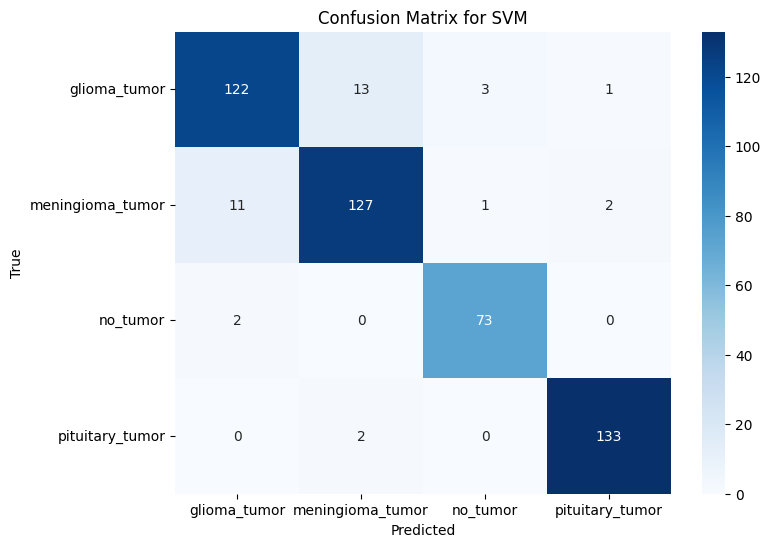

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVM')
plt.show()

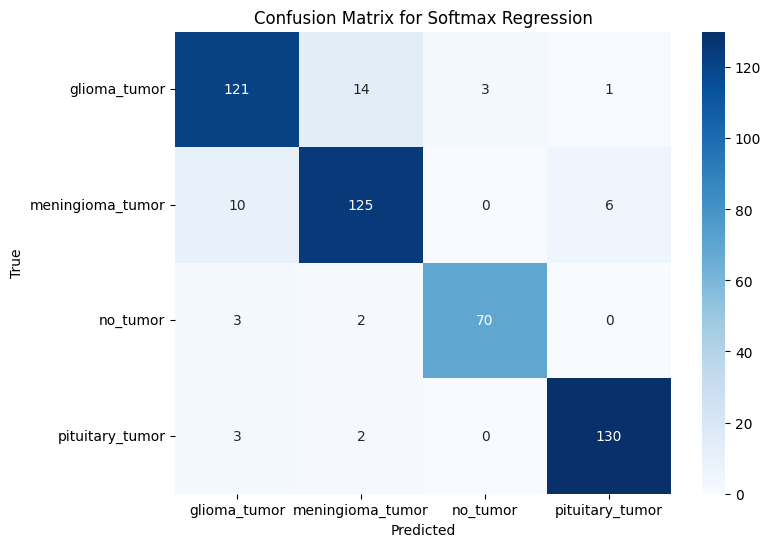

In [23]:
cm = confusion_matrix(y_test, y_test_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Softmax Regression')
plt.show()

Having set the SVM model to produce probabilities, we can plot the ROC curves

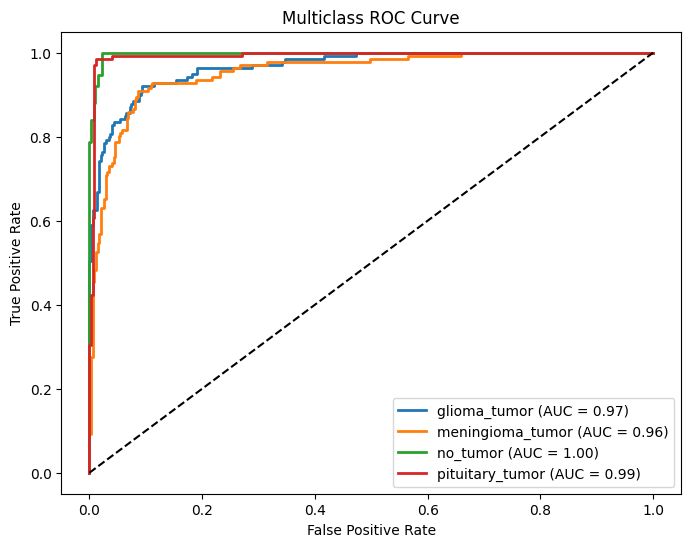

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# binarize the labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=range(len(classes)))

# predict probabilities
y_score = svm_clf.predict_proba(X_test_scaled)

# now, plot the ROC curves
plt.figure(figsize=(8,6))
for i in range(len(classes)):
  fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0,1], "k--")
plt.title("Multiclass ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Visualization

Now let's tackle the visualization aspect, specifically regarding:
* Learning Curves
* Decision Boundaries (with PCA to 2D)
* Feature Importance

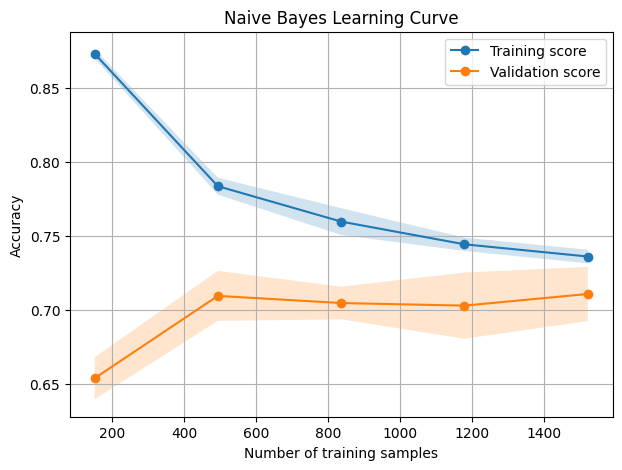

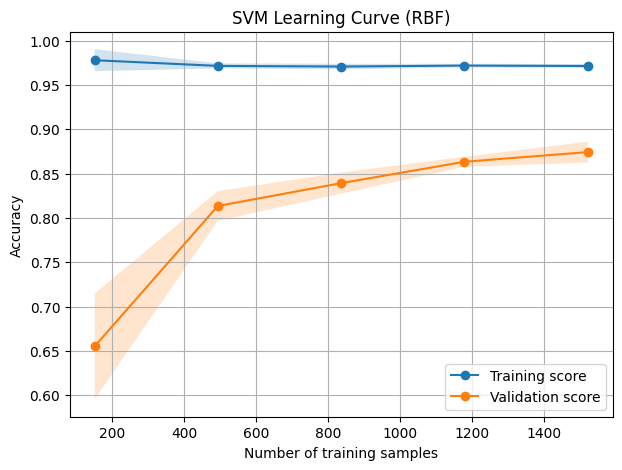

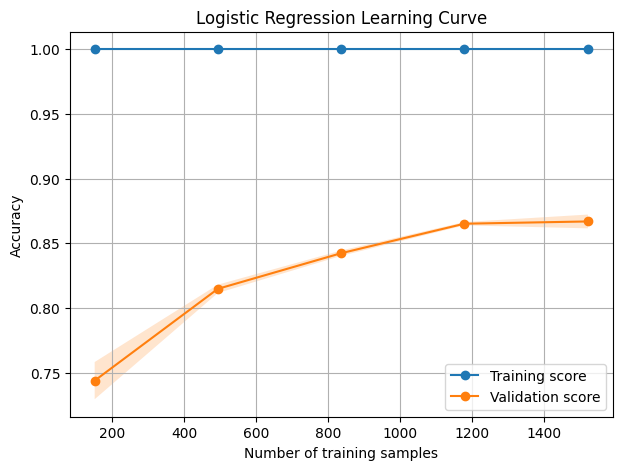

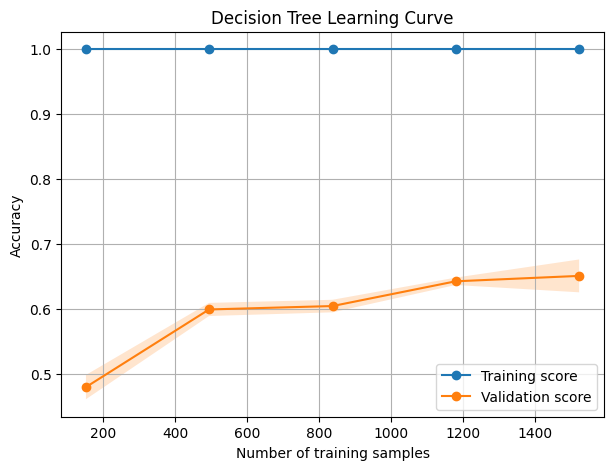

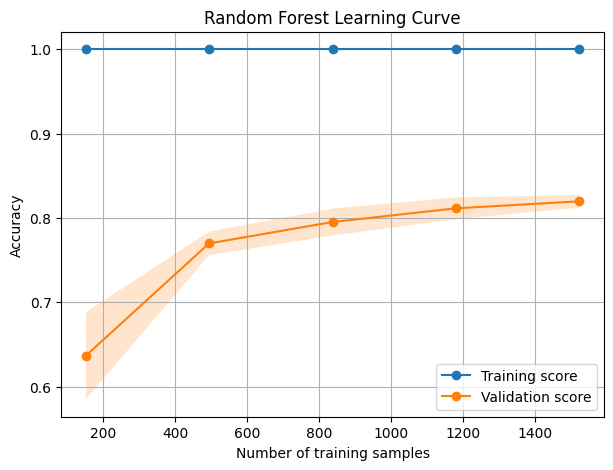

In [25]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, X, y, title, cv=3, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, scoring='accuracy')

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, "o-", label="Training score")
    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.plot(train_sizes, val_mean, "o-", label="Validation score")
    plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)

    plt.title(title)
    plt.xlabel("Number of training samples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# I will only use the training set for learning curves
plot_learning_curve(
    GaussianNB(),
    X_train_scaled, y_train,
    "Naive Bayes Learning Curve",
)

plot_learning_curve(
    SVC(kernel='rbf', probability=True),
    X_train_scaled, y_train,
    "SVM Learning Curve (RBF)",
)

plot_learning_curve(
    LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1),
    X_train_scaled, y_train,
    "Logistic Regression Learning Curve",
)

plot_learning_curve(
    DecisionTreeClassifier(
        random_state=42
    ),
    X_train_scaled, y_train,
    "Decision Tree Learning Curve",
)

plot_learning_curve(
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    X_train_scaled, y_train,
    "Random Forest Learning Curve",
)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


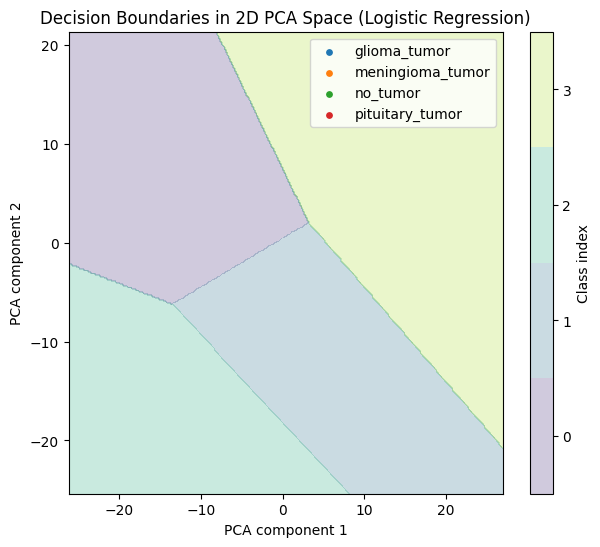

In [26]:
# Decision boundaries using PCA to 2D
'''For visualization only, we project EfficientNet features to 2D with PCA and
fit a simple classifier to show approximate decision regions.
The real model uses the full feature space.'''


from sklearn.decomposition import PCA
# reduce to 2D for visualization (on train only to avoid leakage)
pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train_scaled)
X_val_2d = pca_2d.transform(X_val_scaled)

# fit a simple classfier on 2D features (I can use logistic regression)
clf_2d = LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1)
clf_2d.fit(X_train_2d, y_train)

# meshgrid over the 2D space
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))


Z = clf_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(7,6))
# decision regions
plt.contourf(xx, yy, Z, alpha=0.25, levels=np.arange(len(classes)+1)-0.5)
plt.colorbar(ticks=range(len(classes)), label='Class index')

# plot training points
for i, cls in enumerate(classes):
  mask = (y_train == i)
  plt.scatter(
      X_train_2d[mask, 0],
      X_train_2d[mask, 1],
      s=15,
      label=cls
  )

plt.title("Decision Boundaries in 2D PCA Space (Logistic Regression)")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.legend()
plt.show()

# Feature Importance

Since the SVM with RBF kernel does not provide feature-level interpretability, we extract feature importance from the Logistic Regression baseline using its learned coefficients.

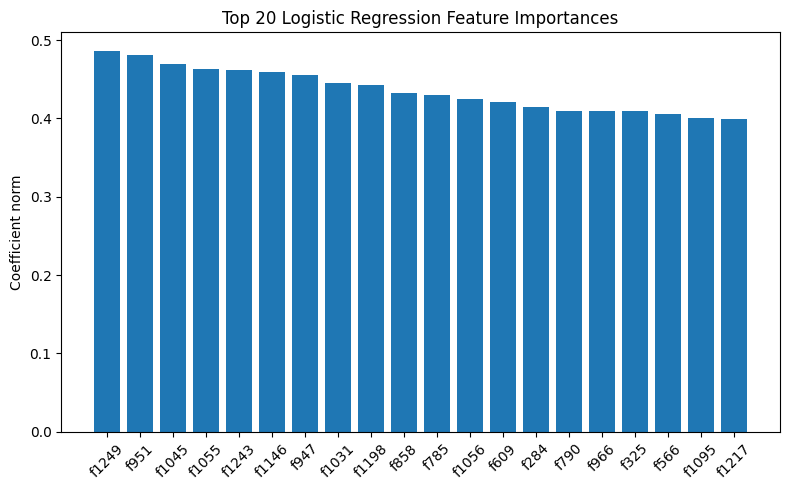

In [28]:
# Logistic regression "importance" per class
coefs = log_reg.coef_    # shape: (n_classes, n_features)

# L2 norm per feature across classes
feature_importance_lr = np.linalg.norm(coefs, axis=0)

indices = np.argsort(feature_importance_lr)[::-1]
top_k = 20

plt.figure(figsize=(8,5))
plt.bar(range(top_k), feature_importance_lr[indices[:top_k]])
plt.xticks(range(top_k), [f"f{indices[i]}" for i in range(top_k)], rotation=45)
plt.ylabel("Coefficient norm")
plt.title("Top 20 Logistic Regression Feature Importances")
plt.tight_layout()
plt.show()

# Manually test the models
Using the trained `svm_clf` and `log_reg` models, along with the `scaler` and `base_model` (EfficientNetB0) to classify a jpg image of a MRI brain scan.

## Image Upload and Preprocessing

This cell creates a widget to upload a file. Upon uploading a JPG image, it gets resized to 224x224, and the EfficientNet preprocessing using the `preprocess_input` function is applied.


In [20]:
from google.colab import files

print("Upload a JPG image file:")
uploaded = files.upload()

# Get the filename of the uploaded image
filename = next(iter(uploaded))
print(f"Uploaded file: {filename}")

# Load and resize the image
img_size = (224, 224)
img = load_img(filename, target_size=img_size)

# Convert to NumPy array
img_array = img_to_array(img)

# Apply EfficientNet preprocessing
preprocessed_img = preprocess_input(img_array)

# Expand dimensions to add a batch dimension
input_image = np.expand_dims(preprocessed_img, axis=0)

print(f"Original image array shape: {img_array.shape}")
print(f"Preprocessed image array shape: {preprocessed_img.shape}")
print(f"Input image shape for model: {input_image.shape}")

Upload a JPG image file:


Saving meningioma.jpg.webp to meningioma.jpg.webp
Uploaded file: meningioma.jpg.webp
Original image array shape: (224, 224, 3)
Preprocessed image array shape: (224, 224, 3)
Input image shape for model: (1, 224, 224, 3)


Now that the image is preprocessed, I will use the pre-trained `base_model` (EfficientNetB0) to extract features from the uploaded image. Then, these features will be scaled using the `scaler` that was previously fitted on the training data, preparing them for input into the classical machine learning models.



In [21]:
print("Extracting features using base_model...")
# Extract features using the pre-trained EfficientNetB0 model
features = base_model.predict(input_image)

print("Scaling features using StandardScaler...")
# Scale the extracted features using the previously fitted scaler
scaled_features = scaler.transform(features)

print(f"Extracted features shape: {features.shape}")
print(f"Scaled features shape: {scaled_features.shape}")

Extracting features using base_model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Scaling features using StandardScaler...
Extracted features shape: (1, 1280)
Scaled features shape: (1, 1280)


I can now use the trained `svm_clf` and `log_reg` models to predict the class of the uploaded image and display their respective probability distributions.



In [22]:
print("\n--- SVM Prediction ---")
svm_pred_proba = svm_clf.predict_proba(scaled_features)[0]
svm_pred_class_idx = np.argmax(svm_pred_proba)
svm_predicted_class = classes[svm_pred_class_idx]

print(f"SVM Predicted Class: {svm_predicted_class}")
print("SVM Probability Distribution:")
for i, prob in enumerate(svm_pred_proba):
  print(f"  {classes[i]}: {prob:.4f}")

print("\n--- Logistic Regression Prediction ---")
log_reg_pred_proba = log_reg.predict_proba(scaled_features)[0]
log_reg_pred_class_idx = np.argmax(log_reg_pred_proba)
log_reg_predicted_class = classes[log_reg_pred_class_idx]

print(f"Logistic Regression Predicted Class: {log_reg_predicted_class}")
print("Logistic Regression Probability Distribution:")
for i, prob in enumerate(log_reg_pred_proba):
  print(f"  {classes[i]}: {prob:.4f}")

print("\n--- Prediction Summary ---")
if svm_predicted_class == log_reg_predicted_class:
  print(f"Both models predict the image belongs to the '{svm_predicted_class}' class.")
else:
  print(f"SVM predicts: '{svm_predicted_class}'")
  print(f"Logistic Regression predicts: '{log_reg_predicted_class}'")


--- SVM Prediction ---
SVM Predicted Class: meningioma_tumor
SVM Probability Distribution:
  glioma_tumor: 0.0557
  meningioma_tumor: 0.9308
  no_tumor: 0.0113
  pituitary_tumor: 0.0022

--- Logistic Regression Prediction ---
Logistic Regression Predicted Class: meningioma_tumor
Logistic Regression Probability Distribution:
  glioma_tumor: 0.0000
  meningioma_tumor: 1.0000
  no_tumor: 0.0000
  pituitary_tumor: 0.0000

--- Prediction Summary ---
Both models predict the image belongs to the 'meningioma_tumor' class.


# Measuring Time and Computational Costs

We will measure time and computational costs on both the best SVM model and the LR model, which again serves as a baseline.

Each test is repeated N times to compute the variance.

In [20]:
# let's start with LR - Training Time
import time
import numpy as np
from sklearn.linear_model import LogisticRegression
import joblib

# number of repeated measurements
N_RUNS = 5
train_times_lr = []

for _ in range(N_RUNS):
    lr_temp = LogisticRegression(
        max_iter=2000,
        multi_class='multinomial',
        n_jobs=-1
    )
    start = time.time()
    lr_temp.fit(X_train_scaled, y_train)
    end = time.time()
    train_times_lr.append(end - start)

lr_training_time_mean = np.mean(train_times_lr)
lr_training_time_std = np.std(train_times_lr)

print(f"LR training time: {lr_training_time_mean:.4f} ± {lr_training_time_std:.4f} seconds")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

LR training time: 1.7441 ± 0.1610 seconds


In [21]:
# inference time (mean ± std)

inference_times_lr = []

for _ in range(N_RUNS):
    start = time.time()
    lr_pred = log_reg.predict(X_test_scaled)
    end = time.time()
    inference_times_lr.append(end - start)

lr_inference_time_mean = np.mean(inference_times_lr)
lr_inference_time_std = np.std(inference_times_lr)

print(f"LR inference time (490 samples): {lr_inference_time_mean:.4f} ± {lr_inference_time_std:.4f} seconds")
print(f"Per-sample inference time: {(lr_inference_time_mean/len(X_test_scaled)):.6f} seconds")

LR inference time (490 samples): 0.0033 ± 0.0017 seconds
Per-sample inference time: 0.000007 seconds


In [22]:
# finally, size

joblib.dump(log_reg, "lr_model.pkl")
!ls -lh lr_model.pkl

-rw-r--r-- 1 root root 41K Nov 21 18:18 lr_model.pkl


Now, we shift our focus to SVM

In [23]:
# training time
train_times_svm = []

for _ in range(N_RUNS):
    svm_temp = SVC(
        C=best_svm.C,
        gamma=best_svm.gamma,
        kernel='rbf',
        probability=True
    )
    start = time.time()
    svm_temp.fit(X_train_scaled, y_train)
    end = time.time()
    train_times_svm.append(end - start)

svm_training_time_mean = np.mean(train_times_svm)
svm_training_time_std = np.std(train_times_svm)

print(f"SVM (best model) training time: {svm_training_time_mean:.4f} ± {svm_training_time_std:.4f} seconds")

SVM (best model) training time: 12.6600 ± 0.1576 seconds


In [24]:
# inference time
inference_times_svm = []

for _ in range(N_RUNS):
    start = time.time()
    svm_pred = best_svm.predict(X_test_scaled)
    end = time.time()
    inference_times_svm.append(end - start)

svm_inference_time_mean = np.mean(inference_times_svm)
svm_inference_time_std = np.std(inference_times_svm)

print(f"SVM (best model) inference on 490 samples: {svm_inference_time_mean:.4f} ± {svm_inference_time_std:.4f} seconds")
print(f"Per-sample inference time: {(svm_inference_time_mean/len(X_test_scaled)):.6f} seconds")

SVM (best model) inference on 490 samples: 0.6985 ± 0.0164 seconds
Per-sample inference time: 0.001425 seconds


In [25]:
# finally, model size
joblib.dump(best_svm, "svm_best_model.pkl")
!ls -lh svm_best_model.pkl

-rw-r--r-- 1 root root 19M Nov 21 18:20 svm_best_model.pkl
